In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras as k
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [258]:
# Load MNIST dataset
MNIST = k.datasets.fashion_mnist.load_data()
#MNIST = k.datasets.mnist.load_data()
# Seperate dataset
training = MNIST[0]
X_train = training[0]
y_train = pd.Series(training[1], name="training targets")
testing = MNIST[1]
X_test = testing[0]
y_test = pd.Series(testing[1], name="testing targets")
# Keep only 1s and 0s for binary classification problem
y_train = y_train[(y_train == 0) | (y_train == 5)]
X_train = X_train[y_train.index]
y_test = y_test[(y_test == 0) | (y_test == 5)]
X_test = X_test[y_test.index]

y_train[y_train==5] = 1
y_test[y_test==5] = 1
X_train[X_train==5] = 1
X_test[X_test==5] = 1

print(y_train)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print()
print(y_train[y_train == 0].shape, y_train[y_train == 1].shape)
print(y_test[y_test == 0].shape, y_test[y_test == 1].shape)

1        0
2        0
4        0
8        1
9        1
        ..
59983    1
59985    0
59995    1
59998    0
59999    1
Name: training targets, Length: 12000, dtype: uint8
(12000, 28, 28) (2000, 28, 28)
(12000,) (2000,)

(6000,) (6000,)
(1000,) (1000,)


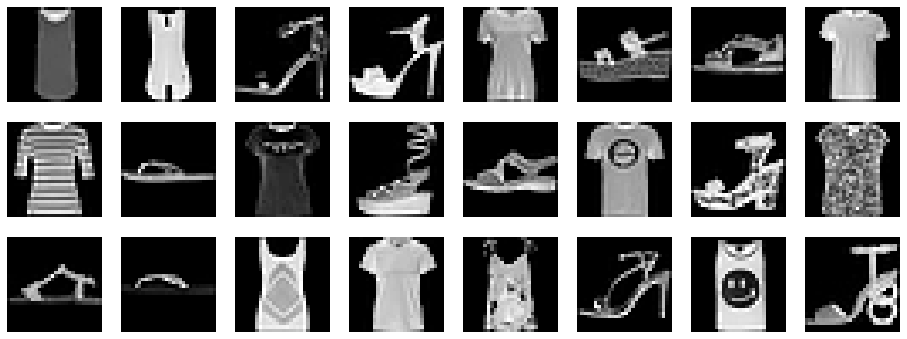

In [259]:
# Visualize training data
plt.figure(figsize=(16,6))
for i in range(24):
    fig = plt.subplot(3, 8, i+1)
    fig.set_axis_off()
    plt.imshow(X_train[i+1], cmap='gray')

# Keras Model

In [262]:
initializer = "random_normal" # random_normal or glorot_uniform
keras_model = k.Sequential([ 
    k.layers.InputLayer(input_shape=(28,28,1)),
    k.layers.Conv2D(filters=32, kernel_size=3, kernel_initializer=initializer),
    k.layers.MaxPooling2D((3,3)),
    k.layers.Flatten(),
    k.layers.Dense(32, activation="relu", kernel_initializer=initializer),
    k.layers.Dense(1, activation="sigmoid", kernel_initializer=initializer)
])
keras_model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_41 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_82 (Dense)             (None, 32)                65568     
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 33        
Total params: 65,921
Trainable params: 65,921
Non-trainable params: 0
_________________________________________________________________


In [263]:
# Select only m samples for fast training time during debugging
m = 1000
X = X_train[:m, :, :].reshape((m, 28, 28, 1))
y = y_train[:m].values.reshape(1,m)
# Compile model
keras_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss='binary_crossentropy')
# Train model
history = keras_model.fit(x=X, y=y.flatten(), epochs=10)

Epoch 1/10
32/32 [==============================] - 0s 4ms/step - loss: 2.3877
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.4299
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.2367
Epoch 4/10
32/32 [==============================] - 0s 4ms/step - loss: 0.1562
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.1190
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0966
Epoch 7/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0817
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0717
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0643
Epoch 10/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0589


In [264]:
m = 1000
X = X_test[:m, :, :].reshape((m, 28, 28, 1))
y = y_test[:m].values.reshape(1,m)

predictions = keras_model.predict_classes(X)
accuracy_score(predictions, y.flatten())

0.981

# Custom CNN

In [247]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.
    Arguments:
    Z -- Output of the linear layer, of any shape
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    m = Y.shape[1]
    #print(AL)
    # Compute loss from aL and y.
    ### START CODE HERE ### (≈ 1 lines of code)
    logprods = np.dot(Y, np.log(AL).T) + np.dot((1-Y), np.log(1-AL).T)
    cost = -1/m*np.sum(logprods)
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    #print(cost)
    return cost

In [274]:
class Layer:
    """
    Interface for layers.
    """
    def __init__(self, input_shape: tuple, output_shape: tuple, trainable=True):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.trainable = trainable
        
    def forward(self, A_prev):
        pass
    
    def backward(self, dZ):
        pass
    
    def update_params(self, learning_rate):
        pass
    
    def __str__(self):
        return self.__class__.__name__ + " " + str(self.output_shape)
    
    
class Dense(Layer):
    def __init__(self, neurons: int, input_shape: tuple, activation: str):
        """
        Constructor for Conv2D layer.
        
        Arguments:
        neurons (N) -- number of neurons
        input_shape -- (N_prev, m)
        activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
        """
        output_shape = (neurons, input_shape[1])
        super().__init__(input_shape, output_shape)
        self.neurons = neurons
        self.activation = activation
        self.initialize_params()
        
    def initialize_params(self):
        '''
        Definitions:
        self.W -- Weights, numpy array of shape (N, N_prev)
        self.b -- Biases, numpy array of shape (N, 1)
        '''
        self.W = np.random.randn(self.neurons, self.input_shape[0]) * 0.01
        self.b = np.zeros((self.neurons,1))
        
        
    def forward(self, A_prev):
        """
        Implement the forward propagation for the dense layer with activation function

        Arguments:
        A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)

        Returns:
        A -- the output of the activation function, also called the post-activation value 
        
        Defintions:
        self.cache -- tuple of values (A_prev, activation_cache) stored for computing backward propagation efficiently

        """
        Z = np.dot(self.W, A_prev) + self.b
        if self.activation == "sigmoid":
            A, activation_cache = sigmoid(Z)

        elif self.activation == "relu":
            A, activation_cache = relu(Z)

        assert (A.shape == (self.W.shape[0], A_prev.shape[1]))
        self.cache = (A_prev, activation_cache)

        return A
    
    def backward(self, dA):
        """
        Implement the backward propagation for the dense layer with activation function

        Arguments:
        dA -- post-activation gradient for current layer l 
       
        Returns:
        dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
        
        Definitions:
        self.dW -- Gradient of the cost with respect to W (current layer l), same shape as W
        self.db -- Gradient of the cost with respect to b (current layer l), same shape as b
        """
        A_prev, activation_cache = self.cache
        m = A_prev.shape[1]

        if self.activation == "relu":
            dZ = relu_backward(dA, activation_cache)
        elif self.activation == "sigmoid":
            dZ = sigmoid_backward(dA, activation_cache)
            
        self.dW = 1/m*np.dot(dZ, A_prev.T)
        self.db = 1/m*np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(self.W.T, dZ)

        return dA_prev
    
    def update_params(self, learning_rate):
        self.W = self.W-learning_rate*self.dW
        self.b = self.b-learning_rate*self.db

        
class Conv2D(Layer):
    def __init__(self, filters: int, filter_size: int, input_shape: tuple, padding="VALID", stride=1):
        """
        Constructor for Conv2D layer.
        
        Arguments:
        filters (C) -- number of filters
        filter_size (f) -- size of filters
        input_shape -- (m, H, W, C)
        """
        output_shape = (input_shape[0], input_shape[1] - filter_size + 1, input_shape[2] - filter_size + 1, filters)
        super().__init__(input_shape, output_shape)
        self.filters = filters
        self.filter_size = filter_size
        self.padding = padding
        self.stride = stride
        self.initialize_params()
    
    def initialize_params(self):
        '''
        Definitions:
        self.W -- Weights, numpy array of shape (f, f, C_prev, n_C)
        self.b -- Biases, numpy array of shape (1, 1, 1, n_C)
        '''
        self.W = np.random.randn(self.filter_size, self.filter_size, self.input_shape[3], self.filters) * 0.001
        self.b = np.zeros((self.filters))
        

    def forward(self, A_prev):
        """
        Implements the forward propagation for a convolution function

        Arguments:
        A_prev -- output activations of the previous layer, numpy array of shape (m, H_prev, W_prev, C_prev)
        
        Returns:
        Z -- conv output
        """
        
        # Perform convolution
        Z = tf.raw_ops.Conv2D(input=A_prev, filter=self.W, strides=[self.stride]*4, padding=self.padding)
        # Add bias
        Z = tf.raw_ops.BiasAdd(value=Z, bias=self.b)
        
        # Save information in "cache" for the backprop
        self.cache = A_prev
        # Return the output
        return Z.numpy()
    
    
    def backward(self, dZ):
        """
        Implement the backward propagation for a convolution function
        
        Arguments:
        dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, H, W, C)
        
        Returns:
        dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
                   numpy array of shape (m, H_prev, W_prev, C_prev)
                   
        Definitions:
        self.dW -- gradient of the cost with respect to the weights of the conv layer (W)
              numpy array of shape (f, f, C_prev, C)
        self.db -- gradient of the cost with respect to the biases of the conv layer (b)
              numpy array of shape (1, 1, 1, C)
        """

        # Retrieve information from "cache"
        A_prev = self.cache
        
        dA_prev = tf.raw_ops.Conv2DBackpropInput(input_sizes = A_prev.shape, filter = self.W, out_backprop = dZ, strides=[self.stride]*4, padding=self.padding).numpy()
        self.dW = tf.raw_ops.Conv2DBackpropFilter(input = A_prev, filter_sizes = self.W.shape, out_backprop = dZ, strides=[self.stride]*4, padding=self.padding).numpy()
        self.db = tf.raw_ops.BiasAddGrad(out_backprop=dZ).numpy()
        return dA_prev
    
       
    def update_params(self, learning_rate):
        self.W = self.W-learning_rate*self.dW
        self.b = self.b-learning_rate*self.db

        
class Maxpool(Layer):
    def __init__(self, input_shape, pool_size=2):
        self.ksize = [1, pool_size, pool_size, 1]
        self.strides = [1, pool_size, pool_size, 1]
        output_shape = (input_shape[0], input_shape[1]//pool_size, input_shape[2]//pool_size, input_shape[3])
        super().__init__(input_shape, output_shape, False)

        
    def forward(self, A_prev):
        Z = tf.raw_ops.MaxPool(input=A_prev, ksize=self.ksize, strides=self.strides, data_format='NHWC', padding="VALID").numpy()
        self.cache = (A_prev, Z)
        return Z
    
    def backward(self, dZ):
        A_prev, Z = self.cache
        dA_prev = tf.raw_ops.MaxPoolGrad(orig_input=A_prev, orig_output=Z, grad=dZ, ksize=self.ksize, strides=self.strides, padding="VALID", data_format='NHWC').numpy()
        return dA_prev
    
        
class ReLU(Layer):
    def __init__(self, input_shape):
        output_shape = input_shape
        super().__init__(input_shape, output_shape, False)
           
    def forward(self, Z):
        """
        Implement the RELU function.
        Arguments:
        Z -- Output of the linear layer, of any shape
        Returns:
        A -- Post-activation parameter, of the same shape as Z
        """

        A = np.maximum(0,Z)
        self.cache = Z 
        return A

    def backward(self, dA):
        """
        Implement the backward propagation for a single RELU unit.
        Arguments:
        dA -- post-activation gradient, of any shape
        Returns:
        dZ -- Gradient of the cost with respect to Z
        """

        Z = self.cache
        dZ = np.array(dA, copy=True) # just converting dz to a correct object.

        # When z <= 0, you should set dz to 0 as well. 
        dZ[Z <= 0] = 0

        return dZ
    

class Flatten(Layer):
    def __init__(self, input_shape):
        m, *shape = input_shape
        output_shape = (np.prod(shape), m)
        super().__init__(input_shape, output_shape, False)
        
    def forward(self, A_prev):
        m, *shape = A_prev.shape
        self.cache = A_prev.shape
        return A_prev.flatten().reshape(m,np.prod(shape)).T
    
    def backward(self, dZ):
        return dZ.T.reshape(self.cache)
    
        
class Model:
    def __init__(self, layers: list):
        self.layers = layers
        self.parameters = dict()
        
    def fit(self, X, Y, epochs, learning_rate, verbose): 
        # Initialize parameters
        history = list()
        for epoch in range(epochs):
            # FORWARD PROP
            Z = X
            for layer in self.layers:    
                if layer.__str__().split()[0] == "knn_differentiable":
                    Z = layer.forward(Z, Y)
                else:
                    Z = layer.forward(Z)
                #print(layer, Z.shape)
            
            # COST FUNCTION
            #print(Z.shape, Z)
            # Keras cost
            loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
            TL = loss(Y, Z)
            print("ALT COST", TL)
            
            # our cost
            cost = compute_cost(Z, Y)
            history.append(cost)
            if verbose == 1:
                print("Cost epoch ", epoch, ": ", cost, end="\n\n")
            
            # BACKWARD PROP
            m = Y.shape[1]
            dA = -(1/m)*(np.divide(Y, Z) - np.divide(1 - Y, 1 - Z)) # derivative of cost with respect to Z
            
            for layer in reversed(self.layers):
                dA = layer.backward(dA)
            
            # UPDATE PARAMS
            for layer in self.layers:
                layer.update_params(learning_rate)

        return history
    
    def predict(self, X, Y):
        Z = X
        for layer in self.layers:
            if layer.__str__().split()[0] == "knn_differentiable":
                Z = layer.forward(Z, Y)
            else:
                Z = layer.forward(Z)
        return Z
    
    def summary(self):
        print("-"*25)
        for layer in layers:
            print(layer)
            print("-"*25)
            
    def _cost(self, X, Y):
        epsilon=1e-7
        Z = X
        for prop_layer in self.layers:
            if prop_layer.__str__().split()[0] == "knn_differentiable":
               #J1 = prop_layer.forward(Z+ epsilon, Y) 
               #J2 = prop_layer.forward(Z- epsilon, Y) 
                
                #print("TESTING: ",(J1-J2)/(2*epsilon))
                
                Z = prop_layer.forward(Z, Y)
            else:
                Z = prop_layer.forward(Z)
            #print(prop_layer, Z)
        # COMPUTE COST
        return compute_cost(Z, Y)
    
    def gradcheck(self, X, Y, epsilon=1e-7, numlayers=None):
        self.approx_grads = []
        self.true_grads = []
        print("Starting loops...")
        j=1
        for layer in self.layers[:numlayers]:
            print(j, len(self.layers))
            j += 1
            if not layer.trainable:
                continue
                
            for i in range(layer.W.size):
                i = np.unravel_index(i, layer.W.shape)
                Wi = layer.W[i]
                layer.W[i] = Wi + epsilon
                J1 = self._cost(X, Y)
                layer.W[i] = Wi - epsilon
                J2 = self._cost(X, Y)
                layer.W[i] = Wi
                #print(J1)
                self.approx_grads.append((J1-J2)/(2*epsilon))
            print("Done W's")  
            for i in range(layer.b.size):
                i = np.unravel_index(i, layer.b.shape)
                bi = layer.b[i]
                layer.b[i] = bi + epsilon
                J1 = self._cost(X, Y)
                layer.b[i] = bi - epsilon
                J2 = self._cost(X, Y)
                layer.b[i] = bi
                #print((J1-J2))
                self.approx_grads.append((J1-J2)/(2*epsilon))
            print("Done B's")
        
        # FORWARD PROP
        Z = X
        for prop_layer in self.layers:
            #print(prop_layer)
            if prop_layer.__str__().split()[0] == "knn_differentiable":
                Z = prop_layer.forward(Z, Y)
            else:
                Z = prop_layer.forward(Z)
                
        # BACKWARD PROP
        m = Y.shape[1]
        dA = -(1/m)*(np.divide(Y, Z) - np.divide(1 - Y, 1 - Z)) # derivative of cost with respect to AL

        for layer in reversed(self.layers):
            dA = layer.backward(dA)
        
        for layer in self.layers[:numlayers]:
            if not layer.trainable:
                continue
            self.true_grads = np.concatenate((self.true_grads, layer.dW.flatten(), layer.db.flatten()))
        return np.sqrt(np.sum(np.square(self.true_grads-self.approx_grads)))/(np.sqrt(np.sum(np.square(self.true_grads)))+np.sqrt(np.sum(np.square(self.approx_grads))))

    
class knn_differentiable(Layer):
    
    def __init__(self, input_shape, num_classes):
        super().__init__(input_shape, num_classes, False)
        
    
    def forward(self, batch_features, batch_labels):
        self.batch_features = np.transpose(batch_features).astype('float')
#         print("BATCH_FEATURES\n", self.batch_features)
#         print()
        self.batch_labels = batch_labels.astype('float')
        
        self.distances = self.calc_distance_mtx(self.batch_features, self.batch_features)
        #self.distances = np.divide(1, self.distances, where=self.distances!=0)
        #print("DISTANCES\n",self.distances)
        #print()
        
        self.class_0 = np.array(self.batch_labels[:] == 0).astype('float')
        self.class_1 = np.array(self.batch_labels[:] == 1).astype('float')
        self.num_0 = np.count_nonzero(self.batch_labels == 0)
        self.num_1 = np.count_nonzero(self.batch_labels == 1)
#         print("SIZES", self.num_0, self.num_1)
#         print()

        self.aggregate = np.stack([np.sum(np.multiply(self.distances, self.class_0), 1) / self.num_0, np.sum(np.multiply(self.distances, self.class_1), 1) / self.num_1], axis=1)
#         print("AGGREGATE\n",aggregate)
#         print()
        
        exp = np.exp(-self.aggregate)
#         print("EXP OF AGGREGATE\n",exp)
#         print(exp[:,0].shape)
#         print()
        
        self.softmax = np.divide(exp[:,1], np.sum(exp, 1))
#         print("SOFTMAX\n",self.softmax[:50])
#         print("="*20)
#         print()
        
        return np.reshape(self.softmax, (1,self.distances.shape[0]))
    
    def backward(self, dA):
        # Overall what we need here:
        # d(TL)/d(X = features) = d(TL)/D(L) * d(L)/d(S) * 
        #     [(d(S)/d(A_0) * d(A_0)/d(D_0) * d(D_0)/d(X)) + (d(S)/d(A_1) * d(A_1)/d(D_1) * d(D_1)/d(X))]
        #
        # Shapes:
        # d(TL)/d(L)  -  (N x 1)           N = number of samples (images)
        # d(L)/d(S)   -  (N x 1)
        # d(S)/d(Ai)  -  (N x 1)
        # d(Ai)/d(Di) -  (N x N)
        # d(Di)/d(X)  -  (N x f)           f = number of features (output by cnn part)
        # final output:  (N x f)
        
        
        # d(TL)/d(L) = -1/m * sum(d(L)/d(S))  <-- Maybe don't need this at all, done before calling backward
        
        
        # d(L)/d(S) = (Y/S) - (1-Y)/(1-S)    <-- Y = true labels, S = softmax labels from column 0 (softmax on class 0)
        dL_dS = dA.T   # <-- Really dTL_dS
        
#         print("dL_dS", dL_dS.shape, dL_dS[:25])
#         print()
        
        
        # d(S)/d(A) = - (e^-A0 * e^-A1) / (e^-2A0 + e^-A0-A1 + e^-2A1)
        # This calc is for A_0 and A_1, A_1 is positive version of this
        #np.square(np.add(np.exp(-self.aggregate[:,0]), np.exp(-self.aggregate[:,1])))
        dS_dA0 = -np.divide(np.multiply(np.exp(-self.aggregate[:,0]), np.exp(-self.aggregate[:,1])), 
                            np.square(np.add(np.exp(-self.aggregate[:,0]), np.exp(-self.aggregate[:,1])))).reshape(self.distances.shape[0],1)
        
        # np.add(np.add(np.exp(-2*self.aggregate[:,0]), np.exp(-2*self.aggregate[:,1])), 
        #                           np.exp(np.multiply(self.aggregate[:,0], self.aggregate[:,1])))
        
        
        dS_dA1 = -dS_dA0
#         print("dS_dA0", dS_dA0.shape, dS_dA0[:25]) (1000,) (1000,1)
#         print()
        
        
        # d(A)/d(D) = 1/len(class) * sum(d(D)/d(X))   <-- Same calc for A_0 and A_1, len(class) = how many of this class there are either num_0 or num_1
        # possibly don't need this part either since its calculated within loops???
        
        
        # d(D)/d(X) = 2(x_i - x_j)   <-- x_i and x_j are the two feature vectors used in the distance
        #distances_0 = 
        dA0_dX = np.ones(self.batch_features.shape)
        # iterate over rows in distance matrix
        for i in range(self.distances.shape[0]):
            dD_dX = np.zeros(self.batch_features.shape[1])
            # iterate over the columns in distance matrix
            for j in range(self.distances.shape[1]):
                # only calculate derivatives for indices of class 0
                if self.class_0[:,j] == 0:
                    # first calc derivative of distance formula, then them all together
                    deriv = -2*(self.batch_features[i,:] - self.batch_features[j,:])
                    dD_dX = np.add(dD_dX, deriv)
            # replace the corresponding derivatives for each row (sample)
            dA0_dX[i,:] = dD_dX
        
        # Same as loop above but on indices of class 1
        dA1_dX = np.ones(self.batch_features.shape)
        for i in range(self.distances.shape[0]):
            dD_dX = np.zeros(self.batch_features.shape[1])
            for j in range(self.distances.shape[1]):
                if self.class_0[:,j] == 1:
                    deriv = -2*(self.batch_features[i,:] - self.batch_features[j,:])
                    dD_dX = np.add(dD_dX, deriv)
            dA1_dX[i,:] = dD_dX
        

        # divide by the number of samples in each class since these were averaged in forward
        dA0_dX = dA0_dX * (1/self.num_0)
        dA1_dX = dA1_dX * (1/self.num_1)
#         print("dD0_dX", dD0_dX.shape, dD0_dX)
#         print()
#         print("dD1_dX", dD0_dX.shape, dD1_dX)
#         print()

        # add together the terms in brackets from the full formula
        dS_dX = np.add(np.multiply(dS_dA0, dA0_dX), np.multiply(dS_dA1, dA1_dX))
        # final step of the chain rule
        dL_dX = np.multiply(dL_dS, dS_dX)
#         print("dL_dX", dL_dX.shape, dL_dX)
        
        print('='*50)
        return dL_dX
        #return np.zeros(self.batch_features.shape)
    
    def calc_distance_mtx(self, A, B):
        """
        Computes squared pairwise distances between each elements of A and each elements of B.
        Args:
        A,    [m,d] matrix
        B,    [n,d] matrix
        Returns:
        D,    [m,n] matrix of pairwise distances
        """
        with tf.compat.v1.variable_scope('pairwise_dist'):
            # squared norms of each row in A and B
            na = tf.reduce_sum(tf.square(A), 1)
            nb = tf.reduce_sum(tf.square(B), 1)

            # na as a row and nb as a co"lumn vectors
            na = tf.reshape(na, [-1, 1])
            nb = tf.reshape(nb, [1, -1])

            # return pairwise euclidead difference matrix
            D = tf.maximum(na - 2*tf.matmul(A, B, False, True) + nb, 0.0)
        return D.numpy()
    
    def calc_cosine_sim(self, A, B):
        from scipy.spatial.distance import pdist
        from scipy.spatial.distance import squareform
        cos_sim = squareform(pdist(A, metric='cosine'))
        return cos_sim

In [302]:
# Select only m samples for fast training time during debugging
np.random.seed(10)
m = 1000
X = X_train[:m, :, :].reshape((m, 28, 28, 1)).astype(float)
y = y_train[:m].values.reshape(1,m)
# Define the layers of the model
layers = [
    Conv2D(16, 7, (None, 28, 28, 1)),
    #ReLU((None, 22, 22, 16)),
    Maxpool((None, 22, 22, 16)),
    Conv2D(16, 9, (None, 11, 11, 16)),
    #ReLU((None, 8, 8, 32)),
    Maxpool((None, 3, 3, 16)),
    Flatten((None, 1, 1, 16)),
    #Dense(32, (5184, None), "relu"),
    #Dense(1, (32, None), "sigmoid")
    knn_differentiable((64, None), 2)
]

# Create and train model
model = Model(layers)
history = model.fit(X, y, epochs=19, learning_rate=0.005, verbose=1)

ALT COST tf.Tensor(0.7120882272720337, shape=(), dtype=float64)
Cost epoch  0 :  0.6850046708614388

ALT COST tf.Tensor(0.712259829044342, shape=(), dtype=float64)
Cost epoch  1 :  0.6857110099846532

ALT COST tf.Tensor(0.7123441696166992, shape=(), dtype=float64)
Cost epoch  2 :  0.6860531609145192

ALT COST tf.Tensor(0.7123494744300842, shape=(), dtype=float64)
Cost epoch  3 :  0.6860638538363617

ALT COST tf.Tensor(0.7122964262962341, shape=(), dtype=float64)
Cost epoch  4 :  0.6858305253263527

ALT COST tf.Tensor(0.7121918201446533, shape=(), dtype=float64)
Cost epoch  5 :  0.6853806515102314

ALT COST tf.Tensor(0.7120203971862793, shape=(), dtype=float64)
Cost epoch  6 :  0.6846511239588726

ALT COST tf.Tensor(0.7117726802825928, shape=(), dtype=float64)
Cost epoch  7 :  0.6836012599003416

ALT COST tf.Tensor(0.7114269137382507, shape=(), dtype=float64)
Cost epoch  8 :  0.6821387480572687

ALT COST tf.Tensor(0.7109457850456238, shape=(), dtype=float64)
Cost epoch  9 :  0.680109843

In [38]:
# Select only m samples for fast training time during debugging
np.random.seed(10)
m = 25
X = X_train[:m, :, :].reshape((m, 28, 28, 1)).astype(float)
y = y_train[:m].values.reshape(1,m)
# Define the layers of the model
layers = [
    Conv2D(16, 7, (None, 28, 28, 1)),
    #ReLU((None, 22, 22, 16)),
    Maxpool((None, 22, 22, 16)),
    Conv2D(16, 9, (None, 11, 11, 16)),
    #ReLU((None, 8, 8, 32)),
    Maxpool((None, 3, 3, 16)),
    Flatten((None, 1, 1, 16)),
    #Dense(32, (5184, None), "relu"),
    #Dense(1, (32, None), "sigmoid")
    knn_differentiable((64, None), 2)
]

# Create and train model
model = Model(layers)
print(model.gradcheck(X,y, epsilon=1e-7))
pd.DataFrame(np.column_stack((model.true_grads, model.approx_grads)), columns=['true grads', 'approx grads'])

Starting loops...
1 6
Done W's
Done B's
2 6
3 6
Done W's
Done B's
4 6
5 6
6 6
0.7606332886651564


,true grads,approx grads
0,-0.013448,0.052668
1,-0.001167,-0.005450
2,0.008330,-0.024818
3,-0.006284,-0.087154
4,-0.026957,-0.009739
...,...,...
21547,0.008351,-0.000017
21548,0.006610,-0.000027
21549,-0.005742,-0.001199
21550,-0.010412,-0.000043


In [305]:
n = 0
m = 1000
X = X_test[n:m, :, :].reshape((m-n, 28, 28, 1)).astype(float)
y = y_test[n:m].values.reshape(1,m-n).astype(float)
predictions = model.predict(X, y)
#print(predictions.type)
print(y[:,:100])
print(predictions[:,:100])
accuracy_score(y.flatten(), predictions.flatten().round())

[[1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0.
  1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0.
  0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.
  1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1.
  1. 0. 1. 1.]]
[[9.99782134e-01 9.97009523e-01 1.37337506e-04 9.46404816e-01
  6.90704573e-05 9.74101262e-01 9.99809256e-01 9.99425688e-01
  9.90399831e-01 9.98837756e-01 9.97187488e-01 9.98325601e-01
  9.98242007e-01 1.05401795e-04 5.48773844e-04 9.99847259e-01
  9.78525398e-01 9.98668656e-01 9.99542083e-01 7.42028968e-04
  9.99935110e-01 3.70559929e-01 7.88044135e-05 3.67217609e-04
  9.99983219e-01 9.95996675e-01 6.99167136e-07 9.71504899e-01
  8.24863613e-05 9.99680162e-01 7.08464084e-05 9.94803851e-01
  1.40228115e-02 9.99696846e-01 4.86904926e-05 1.55464046e-02
  1.88438788e-01 7.93928477e-01 9.50881674e-01 7.06217329e-04
  4.41659884e-02 3.92531689e-02 9.99576280e-01 9.93993961e-01
  9.93

0.862

In [306]:
n = 0
m = 1000
X = X_train[n:m, :, :].reshape((m-n, 28, 28, 1)).astype(float)
y = y_train[n:m].values.reshape(1,m-n).astype(float)
predictions = model.predict(X, y)
#print(predictions.type)
#print(y)
print(predictions)
accuracy_score(y.flatten(), predictions.flatten().round())

[[3.85764229e-04 9.85277430e-01 3.43833509e-03 9.99883427e-01
  9.98405518e-01 6.71777884e-03 9.82325295e-01 9.98442956e-01
  6.84530899e-04 1.14146341e-02 9.99710833e-01 9.99024262e-01
  9.98767792e-01 9.93673534e-01 2.40007849e-02 9.72246170e-01
  1.88699027e-01 9.99678365e-01 9.99919860e-01 3.60122599e-03
  1.88073936e-04 5.93422144e-02 9.99450508e-01 8.27332646e-02
  9.99028639e-01 9.99378269e-01 9.91855178e-01 9.99897943e-01
  4.56351217e-03 1.10823195e-04 9.99507210e-01 1.70341742e-02
  2.92148421e-05 9.38897628e-06 9.99811406e-01 9.99886164e-01
  2.55873999e-04 9.87404683e-01 1.03608088e-01 9.63403672e-01
  7.89872834e-03 9.40205654e-01 2.13537221e-04 9.99873371e-01
  9.90419440e-01 9.97884752e-01 9.41665637e-01 9.51035538e-01
  9.95740067e-01 1.64119429e-02 1.53793864e-03 9.89034541e-01
  1.89272516e-05 1.84020714e-01 9.99743335e-01 4.44887153e-06
  9.82705592e-01 6.34386128e-01 9.98136053e-01 9.89073819e-01
  4.60323814e-06 1.25352190e-04 9.99793796e-01 9.99863420e-01
  7.2771

0.865

In [299]:
# Select only m samples for fast training time during debugging
np.random.seed(10)
m = 1000
X = X_train[:m, :, :].reshape((m, 28, 28, 1)).astype(float)
y = y_train[:m].values.reshape(1,m)
# Define the layers of the model
layers = [
    Conv2D(32, 3, (None, 28, 28, 1)),
    #ReLU((None, 22, 22, 16)),
    Maxpool((None, 26, 26, 32), pool_size=3),
    #Conv2D(32, 7, (None, 8, 11, 16)),
    #ReLU((None, 8, 8, 32)),
    #Maxpool((None, 3, 3, 16)),
    Flatten((None, 8, 8, 32)),
    Dense(32, (2048, None), "relu"),
    Dense(1, (32, None), "sigmoid")
    #knn_differentiable((64, None), 2)
]

# Create and train model
model = Model(layers)
history = model.fit(X, y, epochs=10, learning_rate=1, verbose=1)

ALT COST tf.Tensor(0.7142612934112549, shape=(), dtype=float64)
Cost epoch  0 :  0.6940665632459494

ALT COST tf.Tensor(0.6497443318367004, shape=(), dtype=float64)
Cost epoch  1 :  0.5840913218143071

ALT COST tf.Tensor(0.592679500579834, shape=(), dtype=float64)
Cost epoch  2 :  0.3394713114595835

ALT COST tf.Tensor(0.5629366040229797, shape=(), dtype=float64)
Cost epoch  3 :  0.20405979355619652

ALT COST tf.Tensor(0.532133936882019, shape=(), dtype=float64)
Cost epoch  4 :  0.12614162924324812

ALT COST tf.Tensor(0.5272680521011353, shape=(), dtype=float64)
Cost epoch  5 :  0.08991339563562274

ALT COST tf.Tensor(0.5159204602241516, shape=(), dtype=float64)
Cost epoch  6 :  0.07079479584934406

ALT COST tf.Tensor(0.5122106075286865, shape=(), dtype=float64)
Cost epoch  7 :  0.050889096907715634

ALT COST tf.Tensor(0.5089820623397827, shape=(), dtype=float64)
Cost epoch  8 :  0.043277339519545495

ALT COST tf.Tensor(0.5075609683990479, shape=(), dtype=float64)
Cost epoch  9 :  0.03

In [300]:
n = 0
m = 1000
X = X_test[n:m, :, :].reshape((m-n, 28, 28, 1)).astype(float)
y = y_test[n:m].values.reshape(1,m-n).astype(float)
predictions = model.predict(X, y)
#print(predictions.type)
#print(y)
print(predictions)
accuracy_score(y.flatten(), predictions.flatten().round())

[[8.77207326e-01 9.94833097e-01 9.79809248e-05 9.97895028e-01
  7.40929712e-05 1.24724993e-02 9.29602996e-01 8.97062191e-01
  1.46400582e-02 9.73817108e-01 3.87985278e-02 9.89197861e-01
  9.91299714e-01 3.40512292e-05 5.25271307e-05 9.73182202e-01
  5.49985125e-02 9.78384162e-01 9.83781698e-01 3.21816606e-04
  9.65557178e-01 9.56128453e-03 3.62392639e-05 7.24394553e-05
  8.01361664e-01 9.93379140e-01 5.11446515e-04 1.08092491e-02
  2.34868243e-05 9.32955984e-01 2.71818451e-03 1.12832052e-02
  1.67413933e-03 8.71499702e-01 3.24737336e-05 4.76850096e-04
  1.11995270e-03 3.79755283e-03 9.91219081e-01 9.64353398e-05
  1.95889369e-03 1.79939381e-03 9.93425270e-01 9.94218885e-01
  9.93874154e-01 9.67405856e-01 9.84409320e-01 1.48489755e-04
  1.63816046e-04 2.44439352e-03 8.22548622e-05 1.59960185e-05
  4.50116427e-04 7.48105174e-03 9.83351023e-01 9.97437988e-01
  9.87832287e-01 9.98105418e-01 9.96103842e-01 5.67227076e-05
  5.63560243e-05 9.58004898e-01 1.54702089e-03 2.55725244e-03
  3.2298

0.995